In [ ]:
!pip install tensorflow==1.15
!pip install keras==2.3.1


     |████████████████████████████████| 412.3MB 42kB/s 
     |████████████████████████████████| 512kB 49.0MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 3.8MB 49.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=f636c979cbd1f85be53a8be25d6a6278e38fa875631154cddf2c2f25a7e7d862
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully 

In [ ]:
import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from sklearn.metrics import *
from keras.engine import Model
import numpy as np
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D ,ZeroPadding2D,LeakyReLU
from keras.models import Sequential
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Loading Data

In [ ]:
X_= np.load("drive/My Drive/EmotionDetection/Training_data/train.npz")
Y_ = np.load("drive/My Drive/EmotionDetection/Training_data/test.npz")

X_train , y_train = X_['X'] , X_['Y']
X_test , y_test = Y_['X'] , Y_['Y']

print("Training Data shape {} , {}".format(X_train.shape , y_train.shape))
print("Testing Data shape {} , {}".format(X_test.shape , y_test.shape))

Training Data shape (32298, 48, 48, 1) , (32298, 7)
Testing Data shape (3589, 48, 48, 1) , (3589, 7)


In [ ]:
EPOCHS = 200
BS = 128
DROPOUT_RATE = 0.5
FROZEN_LAYER_NUM = 19

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

# Building the Network Architecture

In [ ]:
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = 3, strides = 1, activation='relu',input_shape=(48,48,1) , padding='same'))
model.add(Conv2D(filters = 64, kernel_size =  3, strides = 1, activation='relu' , padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv2D(filters = 128, kernel_size = 3, strides = 1, activation='relu' , padding='same'))
model.add(Conv2D(filters = 128, kernel_size = 3, strides = 1, activation='relu' , padding='same'))
model.add(MaxPooling2D((2,2), strides= 2 ))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv2D(filters = 256, kernel_size=  3, strides = 1, activation='relu' , padding='same'))
model.add(Conv2D(filters = 256, kernel_size = 3, strides = 1, activation='relu', padding='same'))
model.add(Conv2D(filters = 256, kernel_size = 3, strides = 1, activation='relu' , padding='same'))
model.add(MaxPooling2D((2,2), strides=1))
model.add(Dropout(0.5))
model.add(BatchNormalization())


model.add(Conv2D(filters = 512,kernel_size = 3,strides =  1, activation='relu' , padding='same'))
model.add(Conv2D(filters = 512,kernel_size= 3, strides = 1, activation='relu' , padding='same'))
model.add(Conv2D(filters = 512, kernel_size = 3,strides =  1, activation='relu' , padding='same'))
model.add(Dropout(0.5))
model.add(MaxPooling2D((2,2), strides= 2 ))



model.add(Conv2D(filters = 256,kernel_size = 3,strides =  1, activation='relu' , padding='same'))
model.add(Conv2D(filters = 256,kernel_size =  3,strides = 1, activation='relu' , padding='same'))
model.add(Conv2D(filters = 256,kernel_size =  3,strides =  1, activation='relu' , padding='same'))
model.add(MaxPooling2D((2,2), strides= 2 ))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512))
model.add(LeakyReLU(0.3))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(64))
model.add(LeakyReLU(0.3))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 24, 24, 128)      

In [ ]:
optim = keras.optimizers.Adam(lr=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator 

datagen = ImageDataGenerator(
    rescale=1./255,  # set input mean to 0 over the dataset
    rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,   # randomly flip images
    )


datagen.fit(X_train)
datagen.fit(X_test)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

filepath='drive/My Drive/EmotionDetection/ModelCheckpoint/Vgg3/Model.{epoch:02d}-{accuracy:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='auto' , period = 40)
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_acc',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)

model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
train_flow = datagen.flow(X_train, y_train, batch_size=BS)
validation_flow = datagen.flow(X_test, y_test)

In [ ]:

%%time
history = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train) / BS,
                    epochs=130, 
                    verbose=1, 
                    validation_data=validation_flow, 
                    validation_steps=len(X_test) / BS,
                    callbacks=[checkpointer,rlrop])

Epoch 1/130
253/252 [==============================] - 42s 164ms/step - loss: 2.1626 - accuracy: 0.1969 - val_loss: 1.7849 - val_accuracy: 0.2414
Epoch 2/130
  1/252 [..............................] - ETA: 36s - loss: 1.8919 - accuracy: 0.2500

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


253/252 [==============================] - 39s 156ms/step - loss: 1.9080 - accuracy: 0.2278 - val_loss: 1.8211 - val_accuracy: 0.2435
Epoch 3/130
253/252 [==============================] - 39s 155ms/step - loss: 1.8502 - accuracy: 0.2357 - val_loss: 1.8526 - val_accuracy: 0.2371
Epoch 4/130
253/252 [==============================] - 39s 156ms/step - loss: 1.8233 - accuracy: 0.2411 - val_loss: 1.7047 - val_accuracy: 0.2619
Epoch 5/130
253/252 [==============================] - 39s 155ms/step - loss: 1.8064 - accuracy: 0.2465 - val_loss: 1.7756 - val_accuracy: 0.2586
Epoch 6/130
253/252 [==============================] - 39s 156ms/step - loss: 1.7966 - accuracy: 0.2492 - val_loss: 1.7188 - val_accuracy: 0.1584
Epoch 7/130
253/252 [==============================] - 39s 156ms/step - loss: 1.7843 - accuracy: 0.2554 - val_loss: 1.9364 - val_accuracy: 0.1724
Epoch 8/130
253/252 [==============================] - 40s 156ms/step - loss: 1.7303 - accuracy: 0.2895 - val_loss: 1.7527 - val_accurac

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


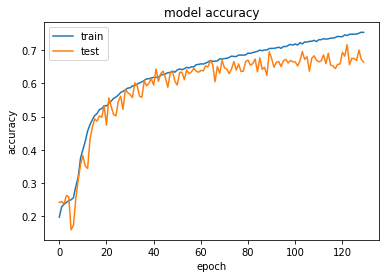

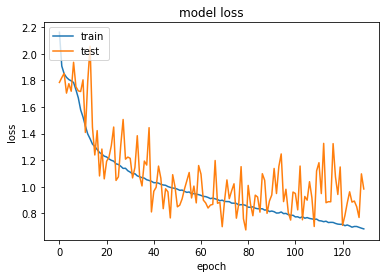

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Saving Model in Json

In [ ]:
from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = model.to_json()


with open("drive/My Drive/EmotionDetection/ModelCheckpoint/Vgg3/Vgg_3_130.json", "w") as json_file:
    json_file.write(model_json)


In [ ]:
# load json and create model
json_file = open('drive/My Drive/EmotionDetection/ModelCheckpoint/Vgg3/Vgg_3_130.json', 'r')

loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("drive/My Drive/EmotionDetection/ModelCheckpoint/Vgg3/Vgg_3_130.hdf5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
model.save_weights("drive/My Drive/EmotionDetection/ModelCheckpoint/Vgg3/Vgg_3_130.hdf5")

In [ ]:
from keras.utils import plot_model

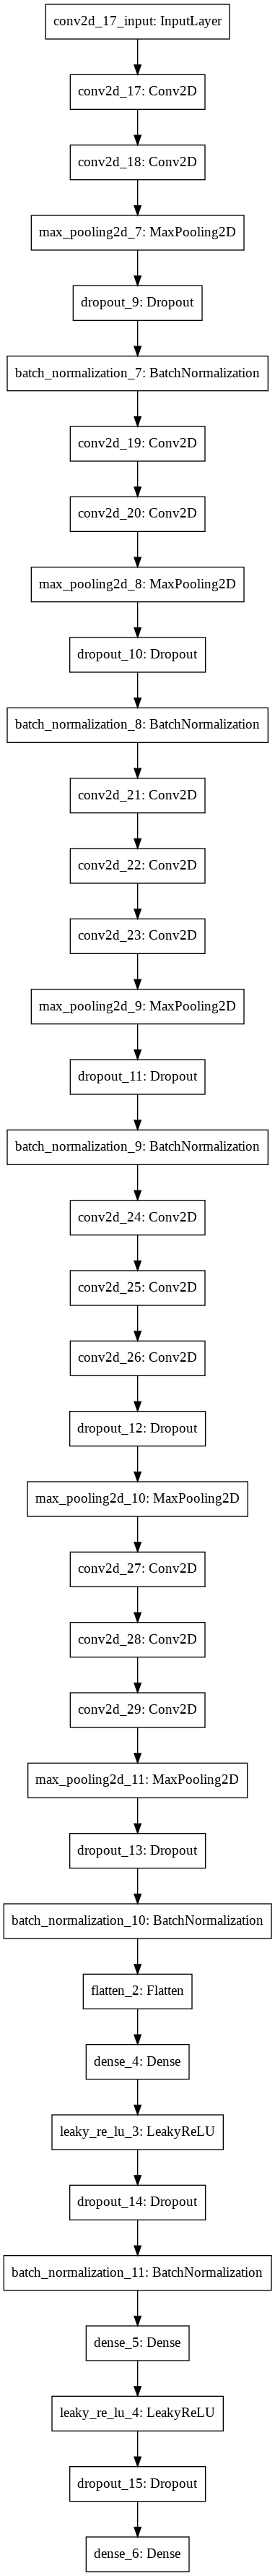

In [ ]:
plot_model(model , to_file = 'drive/My Drive/EmotionDetection/ModelCheckpoint/Vgg3/model.png' )